In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# %tensorflow_version only exists in Colab.
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

import os
import pathlib
import numpy as np
import pandas as pd
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image


print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__) 

Num GPUs Available:  1
Tensorflow version:  2.1.0


#Dataset Import and Overview

In [3]:
np.random.seed(101)
tf.random.set_seed(101)


LABELS_FILE = "/content/drive/My Drive/dogs/train_labels.csv"

df = pd.read_csv(LABELS_FILE)
print(df.head())

CLASS_NAMES = np.unique(df.breed)
BREED_COUNT = 63
class_count = len(CLASS_NAMES)

data_dir = "/content/drive/My Drive/dogs/Dataset/train"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

                                 id               breed
0  a32893132f6fbb3635df77c157c7d8e0  scottish_deerhound
1  3b3ae8c92f704bf449ea4bc61866461b  scottish_deerhound
2  c9bbc4ce586c0d73e14bee1b1e674ba9  scottish_deerhound
3  f194e48d99e5e0f279eb8cd5e6872e36  scottish_deerhound
4  03dc61595ad9dbf49e3998cf586ca8cb  scottish_deerhound
Number of images: 2205


#Image Loading

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count * 0.7 / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
# get a dataset of all files matching the pattern
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/content/drive/My Drive/dogs/Dataset/train/norwegian_elkhound/d9483ad58c5e1ae2e73ac0de09aac90d.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/border_terrier/5501faf6694477c31ea97dede096154c.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/lhasa/4b3f4c910479686b10d676f813da0b3f.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/beagle/58154ab6841198957a50526106c72d72.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/pembroke/4792cc9e614c5aa380ce532a2b182e16.jpg'


In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label  

In [7]:
# apply process_path function to each element of this dataset, and return a new
# dataset containing the transformed elements, in the same order as they 
# appeared in the input.
# set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
    #print("Image tensor: ", image)
    #print("Label tensor:", label)
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label)

Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)


# Data Preparation

In [0]:
def breed_distr(ds):
    for breed in CLASS_NAMES:
        count = 0
        for element in ds.as_numpy_iterator(): 
            label = CLASS_NAMES[element[1] == 1][0]
            if (breed in label):
                count += 1
        print(breed, count)


def split_ds(ds, ds_size, split, cache=True, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
  
    val_size = np.floor(ds_size * split)
    val_ds = ds.take(val_size)
    train_ds = ds.skip(val_size)
    
    return (train_ds, val_ds)


def prepare_for_training(ds, cache=True):
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    # Repeat forever
    ds = ds.repeat()
  
    ds = ds.batch(BATCH_SIZE)
  
    # `prefetch` lets the dataset fetch batches in the background while the 
    # model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
  
    return ds


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

In [0]:
train_ds, val_ds = split_ds(labeled_ds, image_count, 0.3,
                                        cache="./dogs.tfcache")

In [10]:
breed_distr(train_ds)
breed_distr(val_ds)

afghan_hound 39
airedale 35
australian_terrier 44
basenji 50
beagle 40
bernese_mountain_dog 51
blenheim_spaniel 46
border_terrier 44
cairn 36
chow 38
entlebucher 47
great_pyrenees 47
ibizan_hound 39
irish_wolfhound 47
italian_greyhound 46
japanese_spaniel 49
lakeland_terrier 46
leonberg 46
lhasa 42
maltese_dog 43
miniature_pinscher 47
newfoundland 41
norwegian_elkhound 52
papillon 46
pembroke 42
pomeranian 47
pug 44
saluki 45
samoyed 44
scottish_deerhound 39
shih-tzu 48
siberian_husky 42
silky_terrier 44
tibetan_terrier 43
whippet 45
afghan_hound 24
airedale 28
australian_terrier 19
basenji 13
beagle 23
bernese_mountain_dog 12
blenheim_spaniel 17
border_terrier 19
cairn 27
chow 25
entlebucher 16
great_pyrenees 16
ibizan_hound 24
irish_wolfhound 16
italian_greyhound 17
japanese_spaniel 14
lakeland_terrier 17
leonberg 17
lhasa 21
maltese_dog 20
miniature_pinscher 16
newfoundland 22
norwegian_elkhound 11
papillon 17
pembroke 21
pomeranian 16
pug 19
saluki 18
samoyed 19
scottish_deerhound 

In [11]:
batched_train_ds = prepare_for_training(train_ds).cache('./dogs-train.tfcache')
batched_val_ds = val_ds.batch(BATCH_SIZE).cache('./dogs-val.tfcache')


print(batched_train_ds)
print(batched_val_ds)
print(batched_train_ds.element_spec)
print(batched_val_ds.element_spec)

<CacheDataset shapes: ((None, 224, 224, 3), (None, 35)), types: (tf.float32, tf.bool)>
<CacheDataset shapes: ((None, 224, 224, 3), (None, 35)), types: (tf.float32, tf.bool)>
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))


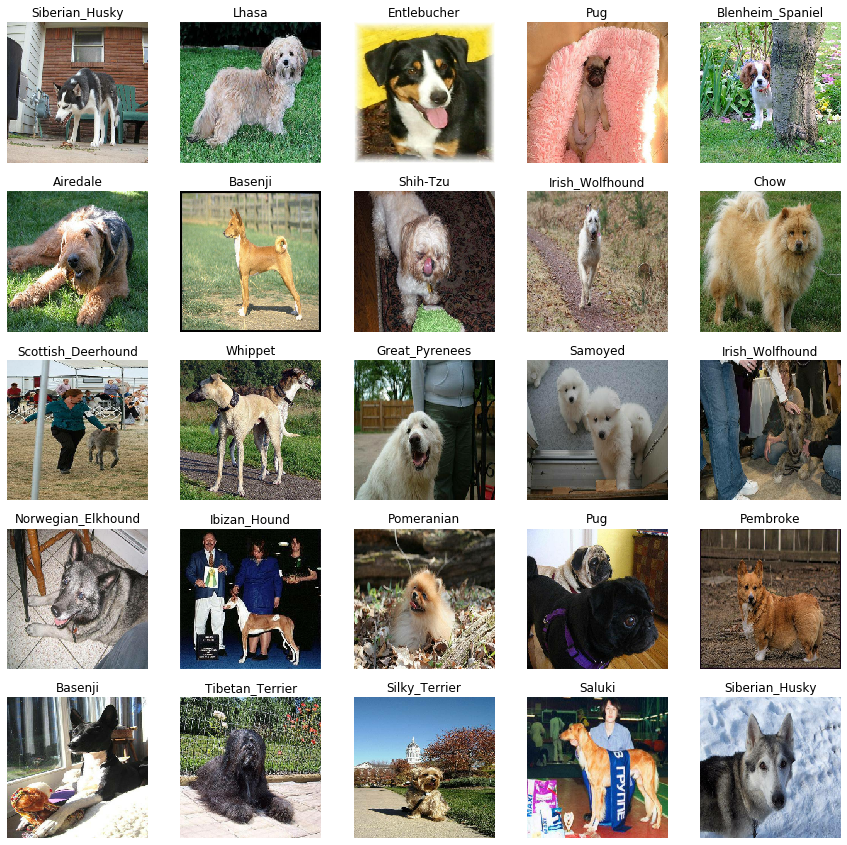

In [15]:
image_batch, label_batch = next(batched_train_ds.as_numpy_iterator())
#image_batch, label_batch = next(batched_val_ds.as_numpy_iterator())

show_batch(image_batch, label_batch)

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()
  
    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [0]:
timeit(batched_train_ds)

....................................................................................................
1000 batches: 19.93191909790039 s
1605.46508 Images/s


# Model

In [45]:
l2_penalty = 0.001
dropout_rate = 0.05

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',
                       kernel_regularizer=regularizers.l2(l2_penalty)))
model.add(layers.Dense(class_count, activation='softmax',
                       kernel_regularizer=regularizers.l2(l2_penalty)))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 52, 52, 64)       

In [0]:
## hyperbolically decreasing learning rate over time
## It is computed as:
## def decayed_learning_rate(step):
##     return initial_learning_rate / (1 + decay_rate * step / decay_step) 
#lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#    initial_learning_rate=0.001,
#    decay_steps=STEPS_PER_EPOCH * 1000,
#    decay_rate=1,
#    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5)

history = model.fit(batched_train_ds, 
                    epochs=10,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=batched_val_ds,
                    steps_per_epoch=STEPS_PER_EPOCH
                    )

Train for 49.0 steps, validate for 21 steps
Epoch 1/10
49/49 [==============================] - 4s 86ms/step - loss: 4.0442 - accuracy: 0.0332 - val_loss: 3.7373 - val_accuracy: 0.0182
Epoch 2/10
49/49 [==============================] - 13s 256ms/step - loss: 3.7012 - accuracy: 0.0306 - val_loss: 3.6747 - val_accuracy: 0.0197
Epoch 3/10
49/49 [==============================] - 22s 454ms/step - loss: 3.6570 - accuracy: 0.0338 - val_loss: 3.6484 - val_accuracy: 0.0151
Epoch 4/10
49/49 [==============================] - 24s 491ms/step - loss: 3.6227 - accuracy: 0.0485 - val_loss: 3.6428 - val_accuracy: 0.0197
Epoch 5/10
49/49 [==============================] - 24s 488ms/step - loss: 3.5187 - accuracy: 0.0644 - val_loss: 3.6733 - val_accuracy: 0.0242
Epoch 6/10
49/49 [==============================] - 25s 505ms/step - loss: 3.2725 - accuracy: 0.1435 - val_loss: 3.8604 - val_accuracy: 0.0287
Epoch 7/10
49/49 [==============================] - 24s 481ms/step - loss: 2.8229 - accuracy: 0.2589

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


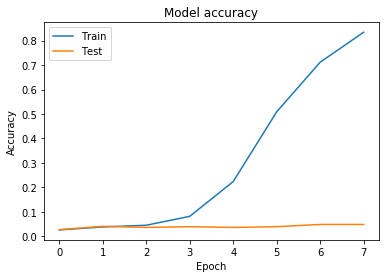

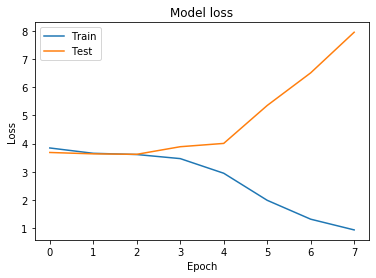

In [44]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
loss, accuracy = model.evaluate(batched_val_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

21/21 [==============================] - 0s 18ms/step - loss: 10.2733 - accuracy: 0.0393
Loss : 10.273267836797805
Accuracy : 0.039334342


In [20]:
predictions = model.predict(batched_val_ds)
print("Number of predictions:", len(predictions))
print(predictions[0])
print(np.argmax(predictions[0]))

Number of predictions: 661
[3.51516028e-05 1.66926539e-09 4.02747613e-09 3.61600428e-06
 8.63563571e-07 2.76876508e-05 1.28844113e-06 4.38589166e-04
 1.76074153e-07 1.36368428e-04 1.92185726e-05 2.60696270e-10
 1.71144420e-05 5.26073836e-06 2.39957490e-06 2.88849993e-08
 1.03260305e-07 5.91245014e-04 4.08375781e-04 1.02052418e-05
 5.86117506e-01 1.82328804e-07 2.03753029e-06 7.76487468e-07
 4.10334200e-01 2.33980791e-06 1.17728305e-05 1.03516768e-05
 6.81227903e-06 3.77796755e-06 1.79360971e-08 2.55332708e-07
 3.36998210e-06 1.80889235e-03 8.35468850e-09]
20


In [0]:
def plot_batch_image(i, predictions_array, image_batch, label_batch):

    predictions_array = predictions_array[i]
    true_label = np.where(label_batch[i] == True)[0][0]
    img = image_batch[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image_batch[i])
  
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100 * np.max(predictions_array),
                                true_label),
                                color=color)
    plt.ylabel(CLASS_NAMES[label_batch[i] == True][0])


def plot_value_array(i, predictions_array, label_batch):
    predictions_array = predictions_array[i]
    true_label = np.where(label_batch[i] == True)[0][0]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(35), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

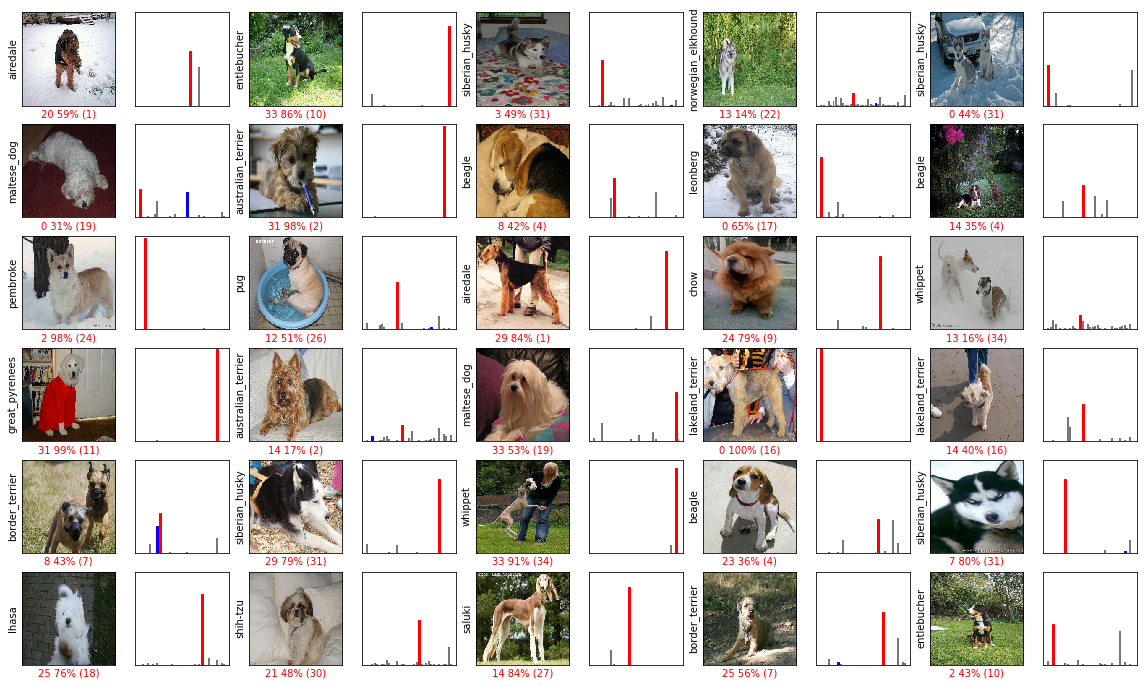

In [22]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 6
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
image_batch, label_batch = next(batched_val_ds.as_numpy_iterator())
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_batch_image(i, predictions, image_batch, label_batch)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, label_batch)
plt.show()